## The market for melatonin products is very chaotic, with products of various doses abounding. The purpose of this assignment is to analyze the proportion of various products (such as 1mg, 2mg, 5mg, 10mg, etc.) based on this data.

In [1]:
# imports
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
import re
import nltk.corpus
nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\roche\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\roche\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roche\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roche\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\roche\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

### Reading the dataset

In [3]:
# Specify the folder containing your CSV files
folder_path = r'C:\Users\roche\OneDrive\Documents\DSEMT-INFO 6105\melatonin\Adult'

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Loop through each CSV file and concatenate it to the combined DataFrame
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df_read = pd.read_csv(file_path)
    df = pd.concat([df_read, df], ignore_index=True)

# Print the combined DataFrame
print(df)


             asin                                      product_title  \
0      B08CGYFB2Q  Vitamatic Melatonin 20mg Tablets | Vegetarian,...   
1      B08CGYFB2Q  Vitamatic Melatonin 20mg Tablets | Vegetarian,...   
2      B08CGYFB2Q  Vitamatic Melatonin 20mg Tablets | Vegetarian,...   
3      B08CGYFB2Q  Vitamatic Melatonin 20mg Tablets | Vegetarian,...   
4      B08CGYFB2Q  Vitamatic Melatonin 20mg Tablets | Vegetarian,...   
...           ...                                                ...   
15905  B00K8K937I  Puritan's Pride Super Strength Rapid Release C...   
15906  B00K8K937I  Puritan's Pride Super Strength Rapid Release C...   
15907  B00K8K937I  Puritan's Pride Super Strength Rapid Release C...   
15908  B00K8K937I  Puritan's Pride Super Strength Rapid Release C...   
15909  B00K8K937I  Puritan's Pride Super Strength Rapid Release C...   

       average_rating  total_reviews      review_author author_badge  \
0                 4.5           1033  Elaine L. Parsons        

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15910 entries, 0 to 15909
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   asin                          15910 non-null  object 
 1   product_title                 15910 non-null  object 
 2   average_rating                15910 non-null  float64
 3   total_reviews                 15910 non-null  int64  
 4   review_author                 15910 non-null  object 
 5   author_badge                  102 non-null    object 
 6   badge                         15601 non-null  object 
 7   reviewed_product_attribute    13815 non-null  object 
 8   reviewed_variant_asin         13815 non-null  object 
 9   variant_review_url            13815 non-null  object 
 10  review_rating                 15910 non-null  int64  
 11  review_date                   15910 non-null  object 
 12  reviewed_country              15910 non-null  object 
 13  r

In [5]:
df.describe()

,average_rating,total_reviews,review_rating,review_comment_count
count,15910.000000,15910.000000,15910.000000,0.0
mean,4.575864,4037.575739,4.191012,NaN
std,0.078619,2070.915748,1.363767,NaN
min,4.500000,768.000000,1.000000,NaN
25%,4.500000,2749.000000,4.000000,NaN
50%,4.600000,3273.000000,5.000000,NaN
75%,4.600000,6594.000000,5.000000,NaN
max,4.700000,6594.000000,5.000000,NaN


### Selecting only required data removing unnecessary features

In [6]:
data = df[['asin', 'product_title', 'brand', 'average_rating','total_reviews', 'review_rating', 'review_text', 'review_header']]
data.head()

,asin,product_title,brand,average_rating,total_reviews,review_rating,review_text,review_header
0,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,20mg in one pill/dose. Easy to swallow. Grape ...,Right dose
1,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Sleep aid,It works as advertized.
2,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Me and my husband have been taking this for aw...,Good Sleep!!
3,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,product works as advertised,works
4,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Works great with no after taste,Works great no after taste


# Add a 'dose' column by extracting the dose from "product_title" column.2

In [7]:
data = data.copy()
pattern = r'(\d+)\s?mg'
data['dose'] = data['product_title'].str.extract(pattern, expand=False).astype(float).astype('Int64')
data

,asin,product_title,brand,average_rating,total_reviews,review_rating,review_text,review_header,dose
0,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,20mg in one pill/dose. Easy to swallow. Grape ...,Right dose,20
1,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Sleep aid,It works as advertized.,20
2,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Me and my husband have been taking this for aw...,Good Sleep!!,20
3,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,product works as advertised,works,20
4,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Works great with no after taste,Works great no after taste,20
...,...,...,...,...,...,...,...,...,...
15905,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,5,This product works. I took one before bed and ...,This product works,<NA>
15906,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,2,"These aren't tablets, and it takes them 1-2 ho...",Poor quality,<NA>
15907,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,3,see above,Product did not help me sleep,<NA>
15908,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,5,I have had trouble falling asleep for the past...,Great purchase! Will buy again!!,<NA>


In [8]:
data.describe(include = "all")

,asin,product_title,brand,average_rating,total_reviews,review_rating,review_text,review_header,dose
count,15910,15910,15910,15910.000000,15910.000000,15910.000000,15882,15905,12710.0
unique,7,7,6,NaN,NaN,NaN,14981,10620,<NA>
top,B07GR9WBFY,Carlyle Melatonin 12 mg Fast Dissolve 180 Tabl...,Carlyle,NaN,NaN,NaN,Great product,Five Stars,<NA>
freq,5000,5000,5760,NaN,NaN,NaN,47,344,<NA>
mean,NaN,NaN,NaN,4.575864,4037.575739,4.191012,NaN,NaN,10.77262
std,NaN,NaN,NaN,0.078619,2070.915748,1.363767,NaN,NaN,4.16771
min,NaN,NaN,NaN,4.500000,768.000000,1.000000,NaN,NaN,1.0
25%,NaN,NaN,NaN,4.500000,2749.000000,4.000000,NaN,NaN,10.0
50%,NaN,NaN,NaN,4.600000,3273.000000,5.000000,NaN,NaN,12.0
75%,NaN,NaN,NaN,4.600000,6594.000000,5.000000,NaN,NaN,12.0


### Checking null values

In [9]:
data.isnull().sum()

asin                 0
product_title        0
brand                0
average_rating       0
total_reviews        0
review_rating        0
review_text         28
review_header        5
dose              3200
dtype: int64

### Filling null values

In [10]:
data.review_text.fillna(value = "", inplace = True)
data.dose.fillna(value = 0, inplace = True)
data.isnull().sum()

asin              0
product_title     0
brand             0
average_rating    0
total_reviews     0
review_rating     0
review_text       0
review_header     5
dose              0
dtype: int64

# Analyze "review_rating": perform sentiment analysis for each dose (not brand).

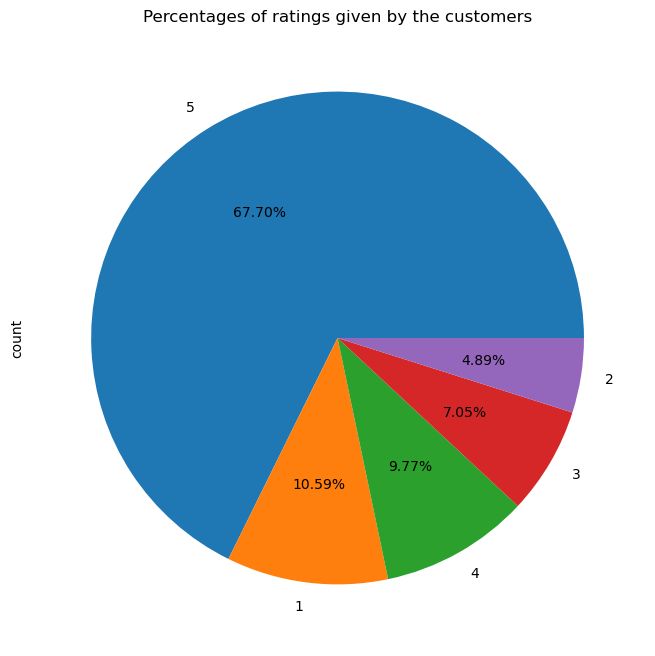

In [11]:
data['review_rating'].value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of ratings given by the customers", loc = "center")
plt.show()

### Labelling Products Based On Ratings Given


In [12]:
def Label(Rows):
  if(Rows["review_rating"] > 3.0):
    Label = "Positive"
  elif(Rows["review_rating"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [13]:
data["sentiment"] = data.apply(Label, axis = 1)

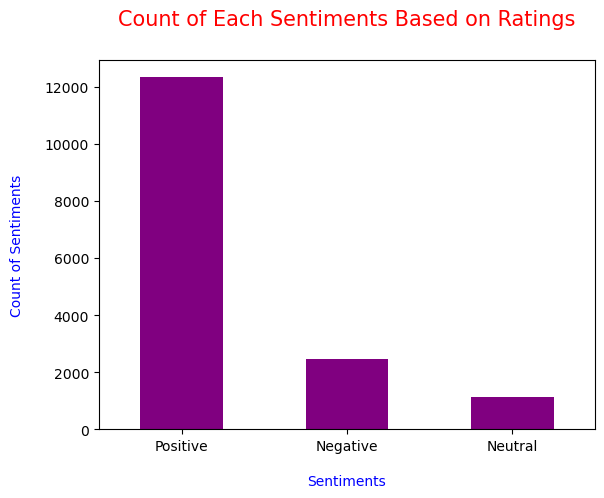

In [14]:
data["sentiment"].value_counts().plot(kind = "bar", color = "purple")
plt.title("Count of Each Sentiments Based on Ratings", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiments", color = "blue", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Count of Sentiments", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

# Analyze the "review_text" column in the data

##### Cleaning the data by removing punctuation marks, links and converting it to lower case

In [15]:
def Text_Cleaning(Text):
    # Check if the value is a string
    if isinstance(Text, str):
        # Lowercase the texts
        Text = Text.lower()

        # Cleaning punctuations in the text
        punc = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        Text = Text.translate(punc)

        # Removing numbers in the text
        #Text = ''.join([i for i in Text if not i.isdigit()])

        # Remove possible links
        Text = re.sub('https?://\S+|www\.\S+', '', Text)

        # Deleting newlines
        Text = re.sub('\n', '', Text)

    return Text

# Apply the Text_Cleaning function to the 'review_text' column
data["review_text_cleaned"] = data["review_text"].apply(lambda Text: Text_Cleaning(Text))


##### Removing unnecessary words by using stopwords. The reason for not removing the word 'not' is that it gives value to certain words for e.g. 'not good', which are an important part of review analysis.

In [16]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
    Processed_Text = []
    Lemmatizer = WordNetLemmatizer()
    
    # Check for NaN values
    if pd.notna(Text):
        # Tokens of Words
        Tokens = nltk.word_tokenize(Text)
        
        # Removing Stopwords and Lemmatizing Words
        
        for word in Tokens:
            if word not in Stopwords:
                Processed_Text.append(Lemmatizer.lemmatize(word))
                
    return " ".join(Processed_Text)

data["review_text_processed"] = data["review_text_cleaned"].apply(lambda Text: Text_Processing(Text))


In [17]:
#Displayed the original review_text column, the review_text_cleaned column and the review_text_processed
data.head(n=10)

,asin,product_title,brand,average_rating,total_reviews,review_rating,review_text,review_header,dose,sentiment,review_text_cleaned,review_text_processed
0,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,20mg in one pill/dose. Easy to swallow. Grape ...,Right dose,20,Positive,20mg in one pill dose easy to swallow grape ...,20mg one pill dose easy swallow grape flavor
1,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Sleep aid,It works as advertized.,20,Positive,sleep aid,sleep aid
2,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Me and my husband have been taking this for aw...,Good Sleep!!,20,Positive,me and my husband have been taking this for aw...,husband taking awhile love take 20 minute bed ...
3,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,product works as advertised,works,20,Positive,product works as advertised,product work advertised
4,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Works great with no after taste,Works great no after taste,20,Positive,works great with no after taste,work great taste
5,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Takes a while to dissolve but does the job onc...,It works!!,20,Positive,takes a while to dissolve but does the job onc...,take dissolve job dissolve
6,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,3,"I liked the fact that these were chewable, but...",too tart,20,Neutral,i liked the fact that these were chewable but...,liked fact chewable extremely tart could chew ...
7,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,1,I used to take 10mg in the past. I decided to ...,Does not make me sleep,20,Negative,i used to take 10mg in the past i decided to ...,used take 10mg past decided increase dose try ...
8,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,3,More mg does not mean you will fall asleep fas...,Melatonin is not a sleeping pill,20,Neutral,more mg does not mean you will fall asleep fas...,mg not mean fall asleep faster not help sleep
9,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,4,I have a hard time sleeping through the night ...,I sleep well now with this product.,20,Positive,i have a hard time sleeping through the night ...,hard time sleeping night melatonin work well k...


In [18]:
# Function to calculate the sentiment score for each review
sia = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

In [19]:
# Check if 'dose' column is present
if 'dose' in data.columns:
    # Filter rows where 'dose' is not null and create a copy
    data_filtered = data[data['dose'].notnull()].copy()

    # Apply the sentiment analysis function to the 'processed_text' column
    data_filtered['sentiment_score'] = data_filtered['review_text_processed'].apply(get_sentiment_score)
else:
    print("The 'dose' column does not exist in the DataFrame.")


In [20]:
# Grouping the reviews by product dose, and calculate the average sentiment score
avg_sentiment_by_dose = data_filtered.groupby(['dose'])['sentiment_score'].mean()
print(avg_sentiment_by_dose)

dose
0     0.373343
1     0.357186
10    0.435098
12    0.370637
20    0.313503
Name: sentiment_score, dtype: float64


C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


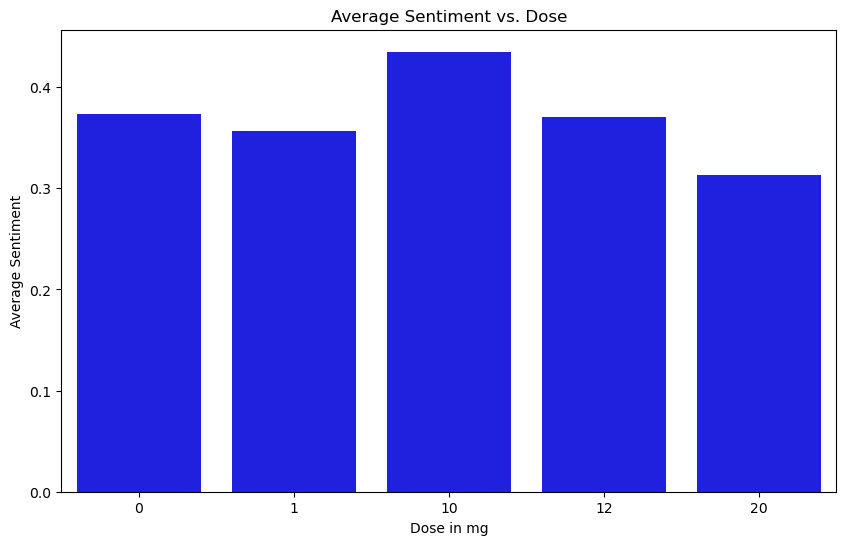

In [21]:
avg_sentiment_by_dose_df = avg_sentiment_by_dose.reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='dose', y='sentiment_score', data=avg_sentiment_by_dose_df, color='b')
plt.title('Average Sentiment vs. Dose')
plt.xlabel('Dose in mg')
plt.ylabel('Average Sentiment')

plt.show()


# EDA

In [22]:
data_filtered

,asin,product_title,brand,average_rating,total_reviews,review_rating,review_text,review_header,dose,sentiment,review_text_cleaned,review_text_processed,sentiment_score
0,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,20mg in one pill/dose. Easy to swallow. Grape ...,Right dose,20,Positive,20mg in one pill dose easy to swallow grape ...,20mg one pill dose easy swallow grape flavor,0.4404
1,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Sleep aid,It works as advertized.,20,Positive,sleep aid,sleep aid,0.0000
2,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Me and my husband have been taking this for aw...,Good Sleep!!,20,Positive,me and my husband have been taking this for aw...,husband taking awhile love take 20 minute bed ...,0.9432
3,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,product works as advertised,works,20,Positive,product works as advertised,product work advertised,0.0000
4,B08CGYFB2Q,"Vitamatic Melatonin 20mg Tablets | Vegetarian,...",Vitamatic,4.5,1033,5,Works great with no after taste,Works great no after taste,20,Positive,works great with no after taste,work great taste,0.6249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15905,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,5,This product works. I took one before bed and ...,This product works,0,Positive,this product works i took one before bed and ...,product work took one bed 30 minute later keep...,0.0000
15906,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,2,"These aren't tablets, and it takes them 1-2 ho...",Poor quality,0,Negative,these aren t tablets and it takes them 1 2 ho...,tablet take 1 2 hour kick wear fast wake 4 5 h...,0.1531
15907,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,3,see above,Product did not help me sleep,0,Neutral,see above,see,0.0000
15908,B00K8K937I,Puritan's Pride Super Strength Rapid Release C...,Puritan's Pride,4.6,3273,5,I have had trouble falling asleep for the past...,Great purchase! Will buy again!!,0,Positive,i have had trouble falling asleep for the past...,trouble falling asleep past five year due tbi ...,0.2023


In [23]:
data_filtered.describe()

,average_rating,total_reviews,review_rating,dose,sentiment_score
count,15910.000000,15910.000000,15910.000000,15910.0,15910.000000
mean,4.575864,4037.575739,4.191012,8.605908,0.385331
std,0.078619,2070.915748,1.363767,5.702953,0.436528
min,4.500000,768.000000,1.000000,0.0,-0.993000
25%,4.500000,2749.000000,4.000000,1.0,0.000000
50%,4.600000,3273.000000,5.000000,10.0,0.457600
75%,4.600000,6594.000000,5.000000,12.0,0.743000
max,4.700000,6594.000000,5.000000,20.0,0.992500


In [24]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15910 entries, 0 to 15909
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   asin                   15910 non-null  object 
 1   product_title          15910 non-null  object 
 2   brand                  15910 non-null  object 
 3   average_rating         15910 non-null  float64
 4   total_reviews          15910 non-null  int64  
 5   review_rating          15910 non-null  int64  
 6   review_text            15910 non-null  object 
 7   review_header          15905 non-null  object 
 8   dose                   15910 non-null  Int64  
 9   sentiment              15910 non-null  object 
 10  review_text_cleaned    15910 non-null  object 
 11  review_text_processed  15910 non-null  object 
 12  sentiment_score        15910 non-null  float64
dtypes: Int64(1), float64(2), int64(2), object(8)
memory usage: 1.6+ MB


C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


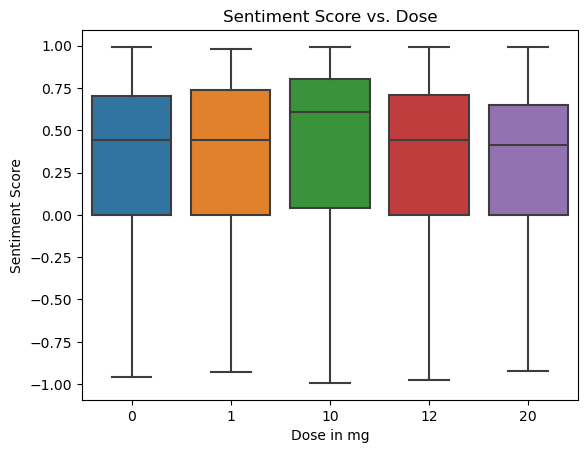

In [25]:
import seaborn as sns
sns.boxplot(x='dose', y='sentiment_score', data = data_filtered)
plt.title('Sentiment Score vs. Dose')
plt.xlabel('Dose in mg')
plt.ylabel('Sentiment Score')
plt.show()

C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\roche\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


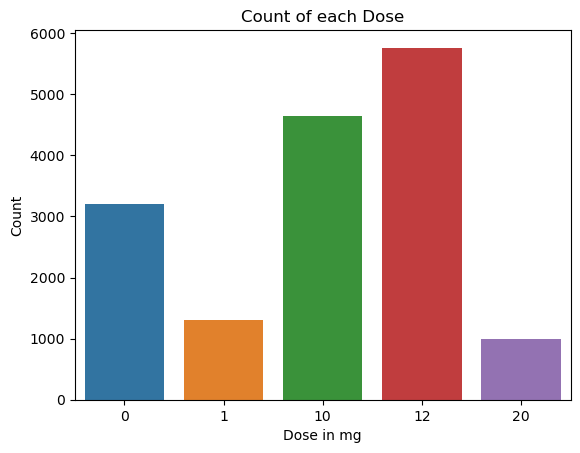

In [26]:
sns.countplot(x='dose', data=data_filtered)
plt.title('Count of each Dose')
plt.xlabel('Dose in mg')
plt.ylabel('Count')
plt.show()

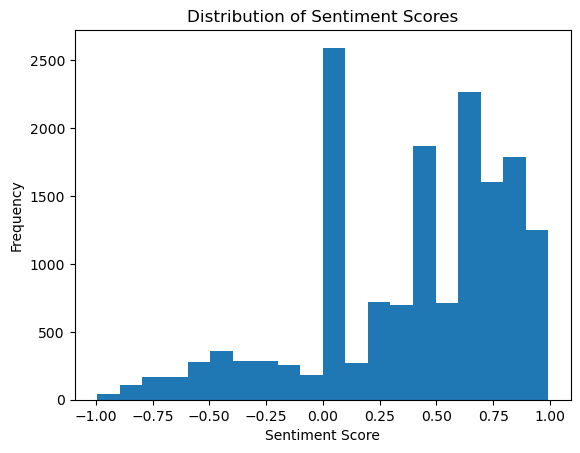

In [27]:
plt.hist(data_filtered['sentiment_score'], bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

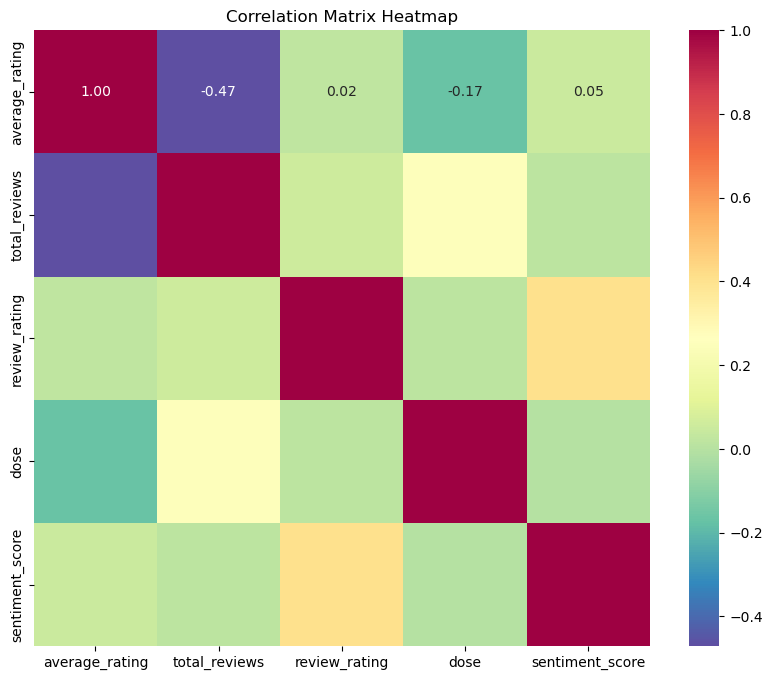

In [28]:
numeric_columns = data_filtered.select_dtypes(include=['float64', 'int64', 'Int64']).columns
correlation = data_filtered[numeric_columns].corr()

plt.figure(figsize=(10, 8))
hm = sns.heatmap(correlation, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=numeric_columns,  
                 xticklabels=numeric_columns,  
                 cmap="Spectral_r")
plt.title("Correlation Matrix Heatmap")
plt.show()


### N-Gram Analysis to identify the most frequently used sequences of words for positive, neutral and negative sentiments

In [29]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words=list(Stopwords), ngram_range=(Gram, Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key=lambda x: x[1], reverse=True)

  return words[:N]


In [30]:
# Filter The DataFrame Based On Sentiments
Positive = data_filtered[data_filtered["sentiment"] == "Positive"].dropna()
Neutral = data_filtered[data_filtered["sentiment"] == "Neutral"].dropna()
Negative = data_filtered[data_filtered["sentiment"] == "Negative"].dropna()

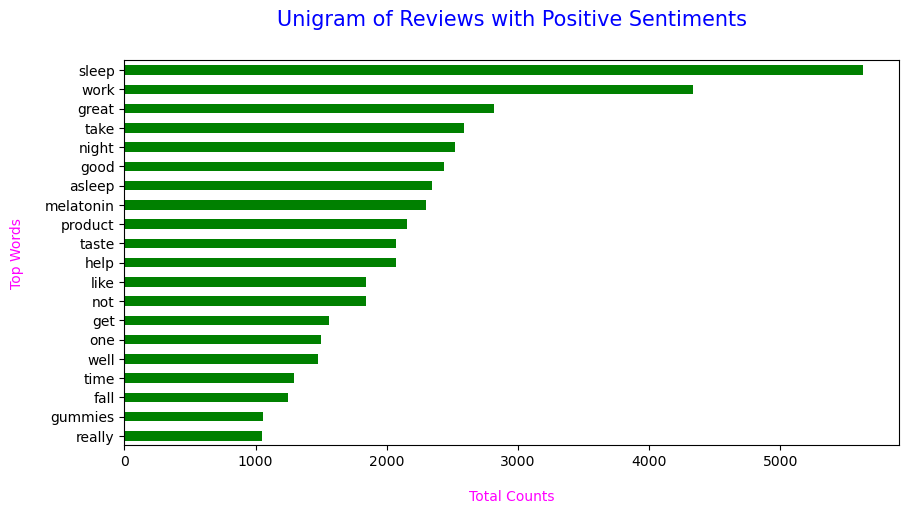

In [31]:

# Finding Unigram
words = Gram_Analysis(Positive["review_text_processed"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()
     

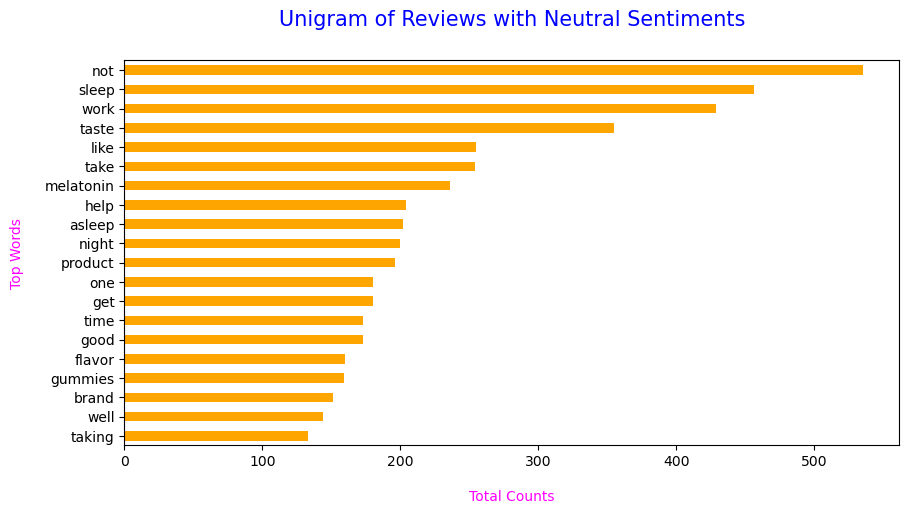

In [32]:

# Finding Unigram
words = Gram_Analysis(Neutral["review_text_processed"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

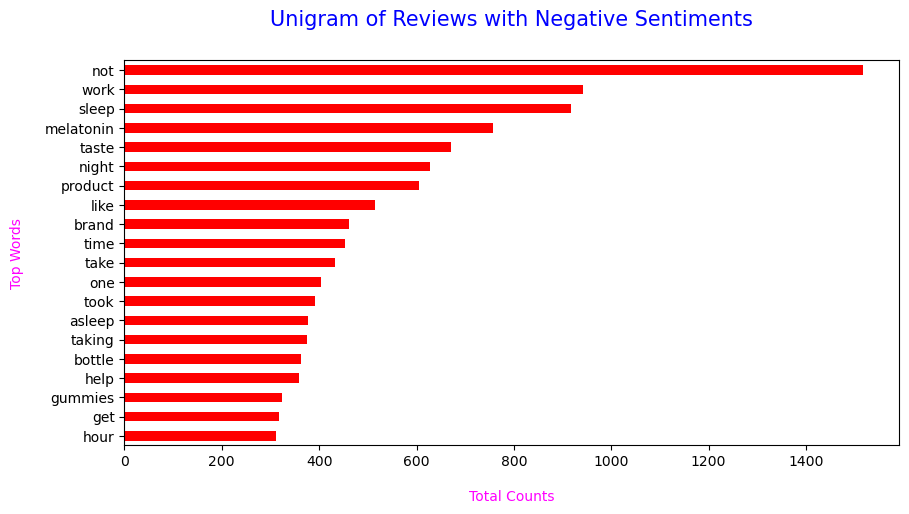

In [33]:
# Finding Unigram
words = Gram_Analysis(Negative["review_text_processed"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

##### These unigrams are not really accurate, because we can clearly see that even for postive sentiments, the top unigram is the word 'sleep' which doesn't give context on the dose. We need to try to find the bigram and see how accurate it can describe each sentiments

### Bigram of Reviews

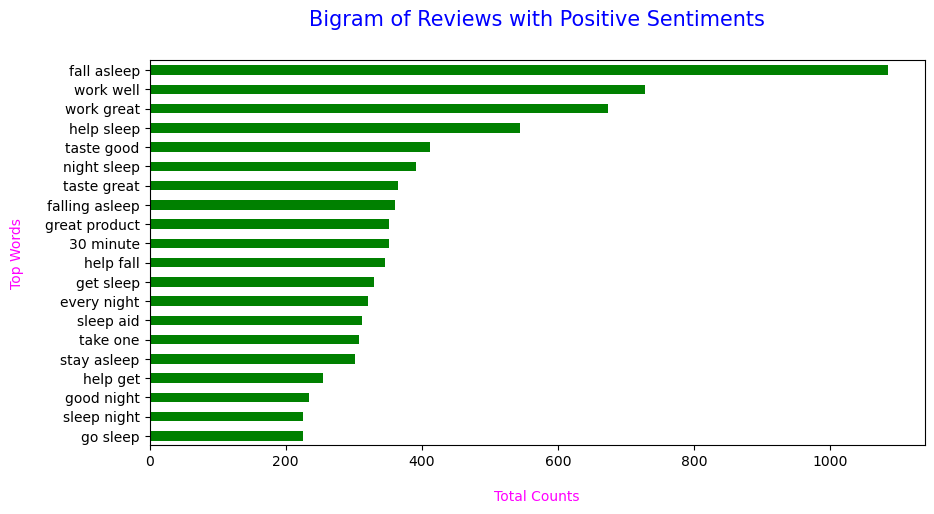

In [34]:
# Finding Bigram
words = Gram_Analysis(Positive["review_text_processed"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

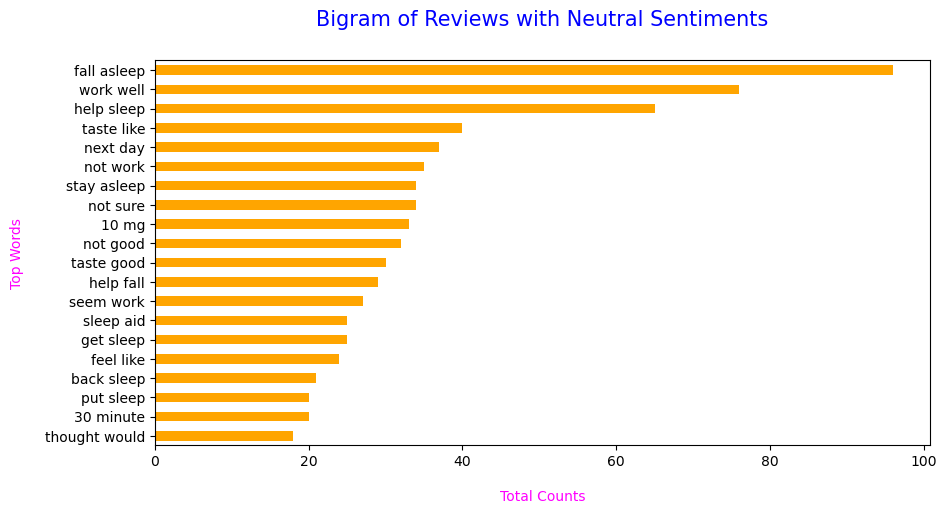

In [35]:

# Finding Bigram
words = Gram_Analysis(Neutral["review_text_processed"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()
     

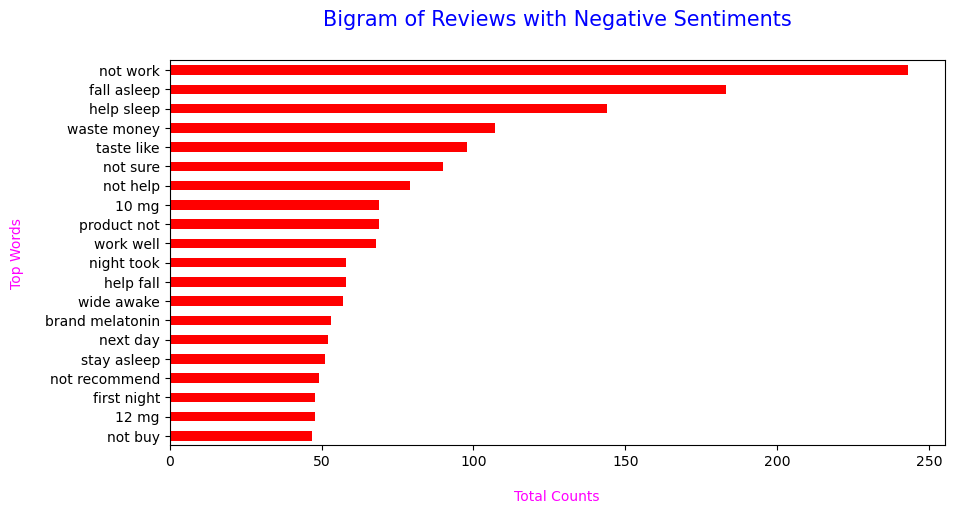

In [36]:

# Finding Bigram
words = Gram_Analysis(Negative["review_text_processed"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

##### The bigrams are more effective than the unigrams since they have specific sentences that effectively convey something about the dose. But it is not clear what do they actually mean.

### Trigram of Reviews

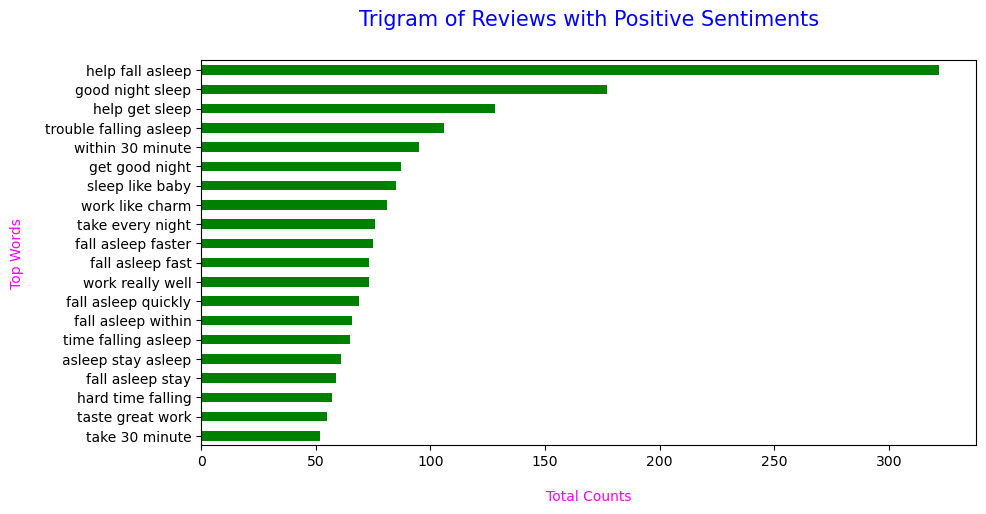

In [37]:
# Finding Trigram
words = Gram_Analysis(Positive["review_text_processed"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

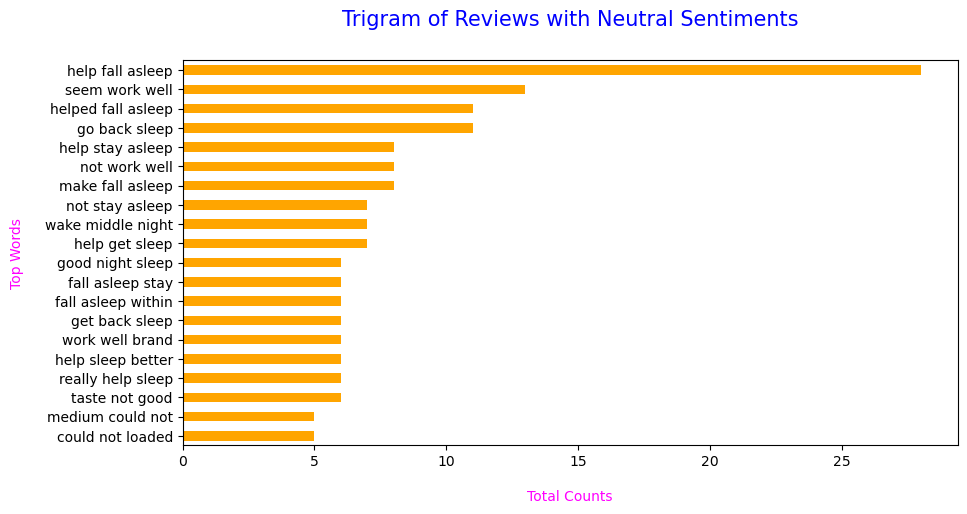

In [38]:

# Finding Trigram
words = Gram_Analysis(Neutral["review_text_processed"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()
     

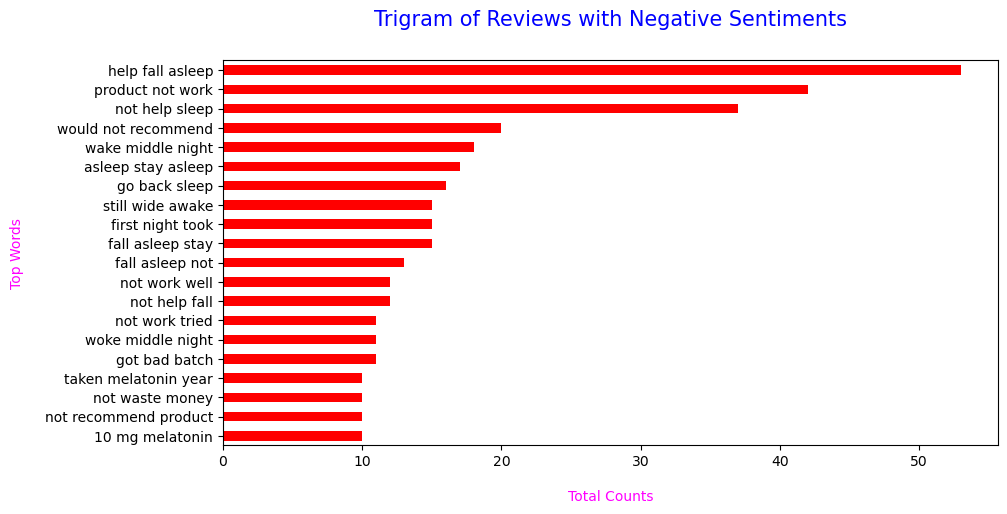

In [39]:
# Finding Trigram
words = Gram_Analysis(Negative["review_text_processed"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Plotting
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

##### From there trigrams, from the negative sentiments, we can see that the reviews are not good for some products. The word 'not' was not removed during text processing because it helps bring more meaning to negative reviews.

# WordCloud

##### Displaying the most frequently occurring words in a given text, with the size of each word indicating its frequency.

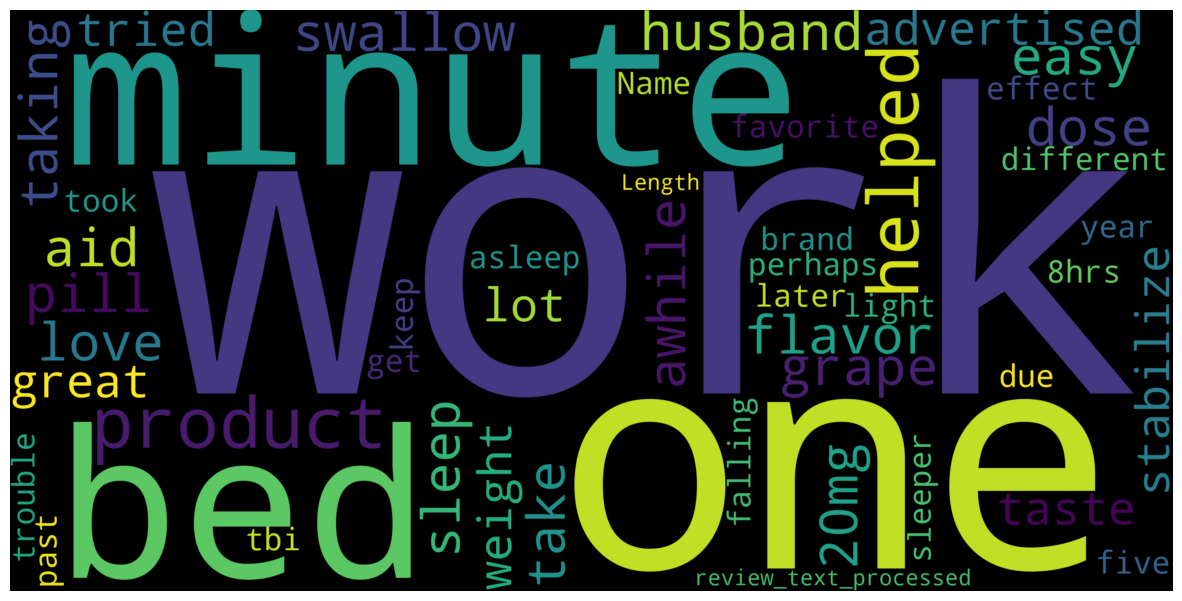

In [40]:
from wordcloud import WordCloud
#
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["review_text_processed"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

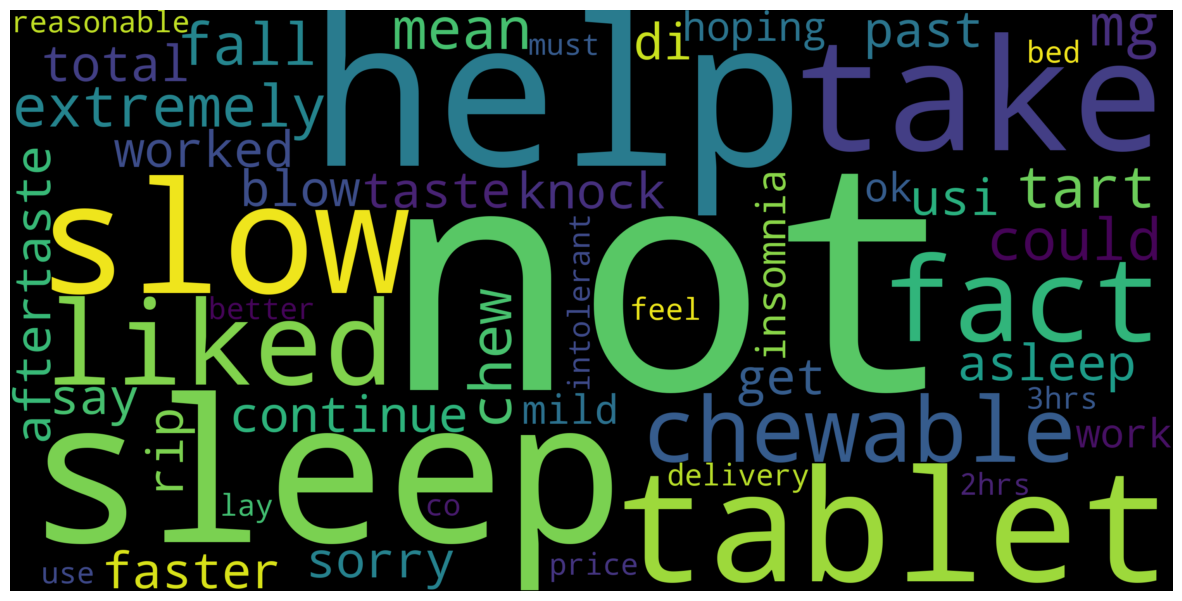

In [41]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["review_text_processed"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

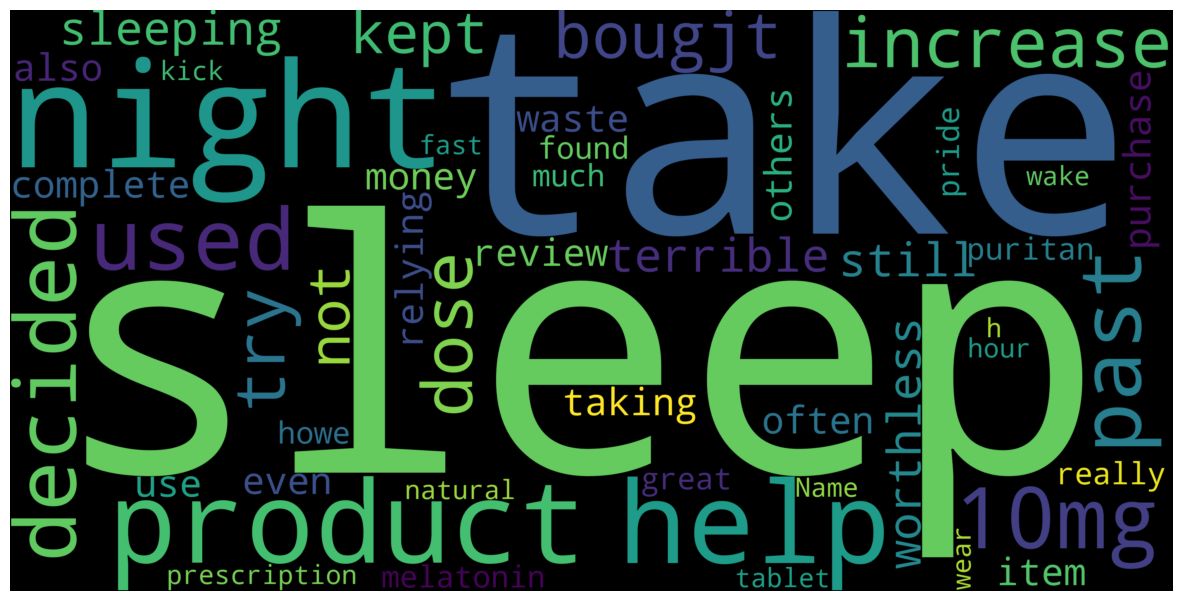

In [42]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["review_text_processed"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
     

### Encoder

In [43]:
Encoder = LabelEncoder()
data_filtered["sentiment"] = Encoder.fit_transform(data_filtered["sentiment"])

In [44]:
data_filtered["sentiment"].value_counts()

sentiment
2    12326
0     2463
1     1121
Name: count, dtype: int64

### TF-IDF Vectorizer

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))
X = TF_IDF.fit_transform(data_filtered["review_text_processed"])
y = data_filtered['dose']

X.shape

(15910, 5000)

##### From the shape, we can see that our data is kind of imbalanced with very little neutral and negative values compared to positive sentiments. We need to balance our dataset before going into modeling process.

### Resampling to balance data

In [46]:
Counter(y)
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

Counter(y_final)

Counter({20: 5760, 12: 5760, 10: 5760, 1: 5760, 0: 5760})

### Splitting the Dataset

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

# Model Selection and Evaluation

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
LogReg = LogisticRegression()


In [49]:
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'SVC Model Accuracy: {accuracy_svc}')
#print(classification_report(y_test, y_pred_svc))


SVC Model Accuracy: 0.5213888888888889


In [50]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Step 3: Model Prediction
y_pred_logreg = logreg_model.predict(X_test)

# Step 4: Model Evaluation
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Model Accuracy: {accuracy_logreg}')
#print(classification_report(y_test, y_pred_logreg))

Logistic Regression Model Accuracy: 0.5423611111111111


##### Text data is typically high-dimensional, especially when represented as word vectors or TF-IDF features. Both SVC and Logistic Regression can handle high-dimensional data efficiently. Both SVC and Logistic Regression are scalable to large datasets, which is important in sentiment analysis when dealing with a large number of reviews or text snippets. From the above accuracy it is clear that Logistic Regression has better accuracy. Going ahead with tuning the hyperparameters.

# Hyperparameter Tuning

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)

Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l2'], "solver": ['lbfgs']}

grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train_scaled, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 61.51 %
Best Parameters: {'C': 16.768329368110066, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\roche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classifier = LogisticRegression(random_state=42, C=0.1, penalty='l2', max_iter=1000)
Classifier.fit(X_train_scaled, y_train)


Prediction = Classifier.predict(X_test_scaled)


# Metrics

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

accuracy_score(y_test, Prediction)

0.6176388888888888

In [54]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)
ConfusionMatrix

array([[ 821,   81,  101,  119,  338],
       [  40, 1089,   21,   18,  234],
       [ 151,  149,  750,  214,  232],
       [ 232,  159,  226,  478,  334],
       [  57,    9,   18,   20, 1309]], dtype=int64)

Unnormalized Confusion Matrix


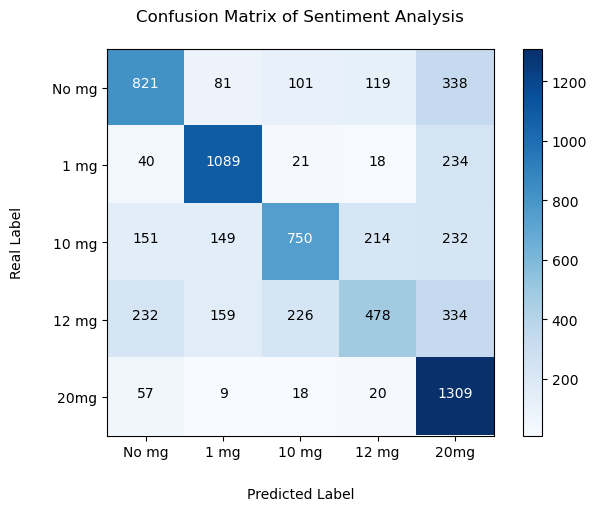

In [55]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")
  
  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)
plot_cm(ConfusionMatrix, classes = ["No mg", "1 mg", "10 mg", "12 mg", "20mg"], title = "Confusion Matrix of Sentiment Analysis")     